In [7]:
from __future__ import absolute_import, division, print_function

import os
import codecs
import glob
import logging
import multiprocessing
import pprint
import re

import nltk
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.manifold

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s',level=logging.INFO)

In [9]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/i318656/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/i318656/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
book_filenames = sorted(glob.glob("GameofThrones/*.txt"))

In [11]:
print("Found books:")
book_filenames

Found books:


['GameofThrones/got1.txt',
 'GameofThrones/got2.txt',
 'GameofThrones/got3.txt',
 'GameofThrones/got4.txt',
 'GameofThrones/got5.txt']

In [12]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r","utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'GameofThrones/got1.txt'...
Corpus is now 1770659 characters long

Reading 'GameofThrones/got2.txt'...
Corpus is now 4071041 characters long

Reading 'GameofThrones/got3.txt'...
Corpus is now 6391405 characters long

Reading 'GameofThrones/got4.txt'...
Corpus is now 8107945 characters long

Reading 'GameofThrones/got5.txt'...
Corpus is now 9719485 characters long



In [13]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [14]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [15]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ",raw)
    words = clean.split()
    return words

In [16]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [17]:
print(raw_sentences[100])

“This is early to come calling, scarce past dawn.


In [18]:
print(sentence_to_wordlist(raw_sentences[100]))

['This', 'is', 'early', 'to', 'come', 'calling', 'scarce', 'past', 'dawn']


In [19]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


### Train Word2Vec

In [20]:
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1

In [21]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling)

In [22]:
thrones2vec.build_vocab(sentences)

2018-05-21 14:09:35,956:INFO:collecting all words and their counts
2018-05-21 14:09:35,957:INFO:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-21 14:09:35,986:INFO:PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2018-05-21 14:09:36,011:INFO:PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2018-05-21 14:09:36,038:INFO:PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2018-05-21 14:09:36,066:INFO:PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2018-05-21 14:09:36,089:INFO:PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2018-05-21 14:09:36,115:INFO:PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2018-05-21 14:09:36,142:INFO:PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2018-05-21 14:09:36,171:INFO:PROGRESS: at sentence #80000, processed 1114967 words

In [23]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


In [24]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=thrones2vec.iter)

/Users/i318656/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.
2018-05-21 14:09:36,642:INFO:training model with 4 workers on 17277 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2018-05-21 14:09:37,662:INFO:EPOCH 1 - PROGRESS: at 20.92% examples, 289967 words/s, in_qsize 7, out_qsize 0
2018-05-21 14:09:38,672:INFO:EPOCH 1 - PROGRESS: at 44.99% examples, 305753 words/s, in_qsize 7, out_qsize 0
2018-05-21 14:09:39,706:INFO:EPOCH 1 - PROGRESS: at 66.72% examples, 305961 words/s, in_qsize 7, out_qsize 0
2018-05-21 14:09:40,745:INFO:EPOCH 1 - PROGRESS: at 90.44% examples, 307182 words/s, in_qsize 7, out_qsize 0
2018-05-21 14:09:41,144:INFO:worker thread finished; awaiting finish of 3 more threads
2018-05-21 14:09:41,156:INFO:worker thread finished; awaiting finish of 2 more threads
2018-05

(7021640, 9090515)

In [25]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [26]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2018-05-21 14:10:00,667:INFO:saving Word2Vec object under trained/thrones2vec.w2v, separately None
2018-05-21 14:10:00,668:INFO:not storing attribute vectors_norm
2018-05-21 14:10:00,670:INFO:not storing attribute cum_table
2018-05-21 14:10:01,015:INFO:saved trained/thrones2vec.w2v


In [27]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2018-05-21 14:10:01,021:INFO:loading Word2Vec object from trained/thrones2vec.w2v
2018-05-21 14:10:01,283:INFO:loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2018-05-21 14:10:01,284:INFO:setting ignored attribute vectors_norm to None
2018-05-21 14:10:01,284:INFO:loading vocabulary recursively from trained/thrones2vec.w2v.vocabulary.* with mmap=None
2018-05-21 14:10:01,285:INFO:loading trainables recursively from trained/thrones2vec.w2v.trainables.* with mmap=None
2018-05-21 14:10:01,285:INFO:setting ignored attribute cum_table to None
2018-05-21 14:10:01,286:INFO:loaded trained/thrones2vec.w2v


In [28]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [29]:
all_word_vectors_matrix = thrones2vec.wv.vectors

In [30]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [31]:
points = pd.DataFrame(
[
    (word, coords[0], coords[1])
    for word, coords in [
        (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
        for word in thrones2vec.wv.vocab
    ]
],
    columns = ["word", "x", "y"]
)

In [32]:
points.head(10)

,word,x,y
0,This,28.592117,-29.451530
1,edition,-56.722710,-30.295181
2,the,6.000623,6.153109
3,complete,8.630990,-27.160839
4,of,-20.289042,-16.908918
5,original,-22.680477,-4.805661
6,hardcover,-52.229355,-21.164188
7,ONE,-47.305336,-28.090061
8,A,18.908266,9.566352
9,OF,-58.290379,-32.458622


In [33]:
sns.set_context("poster")

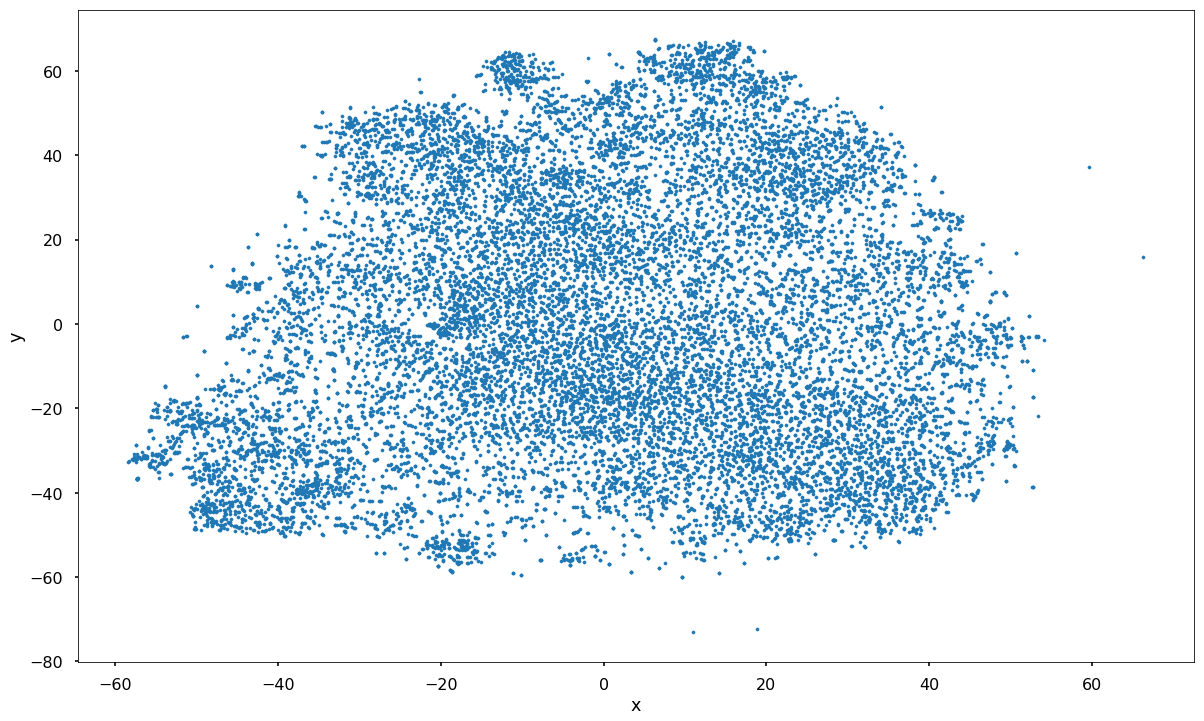

In [34]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [35]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

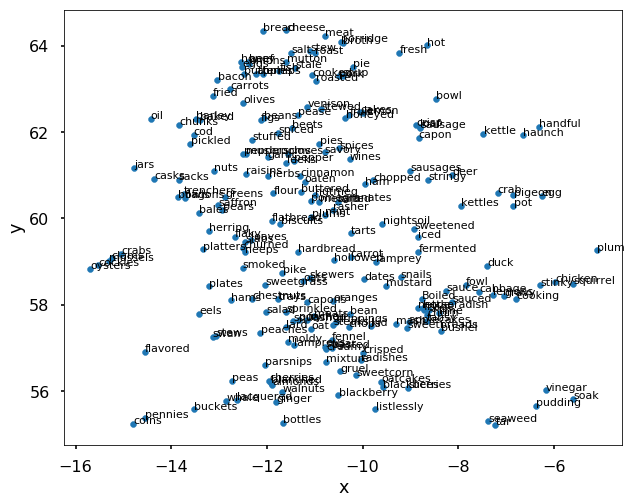

In [38]:
plot_region(x_bounds=(-20, -5), y_bounds=(55, 65))

In [37]:
thrones2vec.most_similar("nuts")

/Users/i318656/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2018-05-21 14:20:42,306:INFO:precomputing L2-norms of word weight vectors


[('pears', 0.9637779593467712),
 ('herring', 0.9465897083282471),
 ('raisins', 0.9458448886871338),
 ('sweetgrass', 0.9424033164978027),
 ('buttered', 0.9407275915145874),
 ('flaky', 0.9401117563247681),
 ('sacks', 0.9359880089759827),
 ('barley', 0.9359775185585022),
 ('slabs', 0.9339145421981812),
 ('bales', 0.9336138963699341)]